In [1]:
# load dataset 
from sklearn.datasets import load_diabetes
import pandas as pd

dataset = load_diabetes()

df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target


In [ ]:
# split data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns='target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# optuna

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 300)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 5, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 15)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse
    

In [19]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Lihat hasil tuning
print('\nbest Hyperparameters : ', study.best_trial.params)
print('best accuracy :', study.best_trial.value)

[I 2025-03-22 18:55:50,403] A new study created in memory with name: no-name-d184dd9c-4daf-4e21-9c6c-7962f30e4deb
[I 2025-03-22 18:55:50,679] Trial 0 finished with value: 2692.0169998760925 and parameters: {'n_estimators': 173, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 0 with value: 2692.0169998760925.
[I 2025-03-22 18:55:51,070] Trial 1 finished with value: 2679.3447130984496 and parameters: {'n_estimators': 273, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 1 with value: 2679.3447130984496.
[I 2025-03-22 18:55:51,164] Trial 2 finished with value: 2724.5410643570804 and parameters: {'n_estimators': 67, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 15}. Best is trial 1 with value: 2679.3447130984496.
[I 2025-03-22 18:55:51,397] Trial 3 finished with value: 2703.4170998865643 and parameters: {'n_estimators': 160, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 1 with value


best Hyperparameters :  {'n_estimators': 71, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 10}
best accuracy : 2637.9809673899495


In [16]:
# Ambil hyperparameter terbaik dari hasil tuning Optuna
best_rf = study.best_trial.params

# Ambil parameter dari dictionary best_rf
n_estimators = best_rf['n_estimators']
max_depth = best_rf['max_depth']
min_samples_split = best_rf['min_samples_split']
min_samples_leaf = best_rf['min_samples_leaf']

# Buat model dengan hyperparameter terbaik
best_model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)

# Train ulang model dengan data training
best_model.fit(X_train_scaled, y_train)

# Evaluasi model
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)

print(f'Best Hyperparameters: {best_rf}')
print(f'Accuracy: {mse:.4f}')


Best Hyperparameters: {'n_estimators': 36, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 10}
Accuracy: 2633.8078


## Klasifikasi

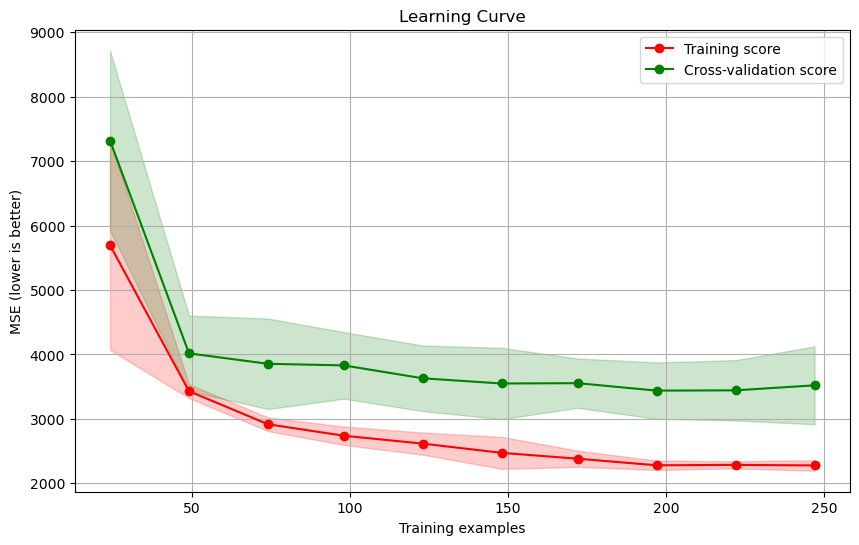

In [20]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Ubah negatif MSE ke positif biar lebih intuitif
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('MSE (lower is better)')  # Lebih jelas
plt.legend(loc="best")
plt.grid()
plt.show()
